In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["first_active_month"])
test = pd.read_csv("data/test.csv", parse_dates=["first_active_month"])
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [3]:
# Handle missing values
print(train.isnull().sum())
print(test.isnull().sum())

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64


In [ ]:
# Remove rows in the test set that are missing the `first_active_month`.
test = test.dropna(subset=['first_active_month'])
print(train.isnull().sum())
print(test.isnull().sum())

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64


In [5]:
# Extract month from first_active_month
train['month'] = train['first_active_month'].dt.month
test['year'] = test['first_active_month'].dt.month

# Extract year from first_active_month
train['year'] = train['first_active_month'].dt.year
test['year'] = test['first_active_month'].dt.year

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017


In [ ]:
# Import the `historical_transactions.csv` file, which contains past customer purchases.
# This dataset will be used to engineer transaction-based features such as total purchase amount, frequency, and variability.
historical_transactions = pd.read_csv("data/historical_transactions.csv")
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [7]:
def aggregate_transaction_amount_stats(transactions_df, prefix):
    """
    Aggregates purchase amount statistics per card_id.
    """
    agg = transactions_df.groupby("card_id")["purchase_amount"].agg(['count', 'sum', 'mean', 'std', 'min', 'max']).reset_index()
    agg.columns = ["card_id"] + [f"{prefix}_{stat}_transactions" for stat in ['num', 'sum', 'mean', 'std', 'min', 'max']]
    return agg


In [ ]:
# We apply the aggregation function to historical transactions and merge the resulting summary features into both the `train` and `test` datasets using `card_id`.
# This enriches the training data with past spending behavior.
hist_transaction_stats = aggregate_transaction_amount_stats(historical_transactions, prefix="hist")

# Merge with training and test set
train = train.merge(hist_transaction_stats, on="card_id", how="left")
test = test.merge(hist_transaction_stats, on="card_id", how="left")

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,hist_num_transactions,hist_sum_transactions,hist_mean_transactions,hist_std_transactions,hist_min_transactions,hist_max_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,260,-165.968739,-0.638341,0.212139,-0.739395,2.258395
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,350,-210.006336,-0.600018,0.384967,-0.742400,4.630299
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,43,-29.167391,-0.678311,0.087380,-0.730138,-0.145847
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,77,-49.491364,-0.642745,0.261624,-0.740897,1.445596
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,133,-48.687656,-0.366073,1.352094,-0.746156,7.193041


In [9]:
def plot_loyalty_vs_transaction_count(
    df, 
    count_col, 
    target_col='target', 
    title_prefix='', 
    outlier_cutoff=None, 
    reverse=False, 
    figsize=(15, 6)
):
    """
    Plots mean loyalty score (target) vs transaction count with optional outlier removal.
    """
    cnt_srs = df.groupby(count_col)[target_col].mean().sort_index()
    
    x_vals = cnt_srs.index[::-1] if reverse else cnt_srs.index
    y_vals = cnt_srs.values[::-1] if reverse else cnt_srs.values

    plt.figure(figsize=figsize)

    # Plot 1: All Points
    plt.subplot(1, 2, 1)
    plt.scatter(x_vals, y_vals, color='orange', alpha=0.6)
    plt.title(f'{title_prefix}All Transaction Points')
    plt.xlabel(count_col.replace('_', ' ').title())
    plt.ylabel('Mean Loyalty Score')
    plt.grid(True, alpha=0.3)

    # Plot 2: Filtered
    plt.subplot(1, 2, 2)
    if outlier_cutoff:
        cnt_srs_filtered = cnt_srs[:-outlier_cutoff]
    else:
        cnt_srs_filtered = cnt_srs

    x_vals_f = cnt_srs_filtered.index[::-1] if reverse else cnt_srs_filtered.index
    y_vals_f = cnt_srs_filtered.values[::-1] if reverse else cnt_srs_filtered.values

    plt.scatter(x_vals_f, y_vals_f, color='orange', alpha=0.6)
    plt.title(f'{title_prefix}Without Last {outlier_cutoff} Points' if outlier_cutoff else f'{title_prefix}Filtered')
    plt.xlabel(count_col.replace('_', ' ').title())
    plt.ylabel('Mean Loyalty Score')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

We use the above function to examine how the number of historical transactions relates to the loyalty score.

- **Left plot:** Shows the mean loyalty score across the full transaction range.
- **Right plot:** Omits the top 50 most active users to remove outliers and clarify the trend.

**Observation:** Loyalty score tends to **decrease** as historical transaction count increases, suggesting heavy users may be less loyal on average.

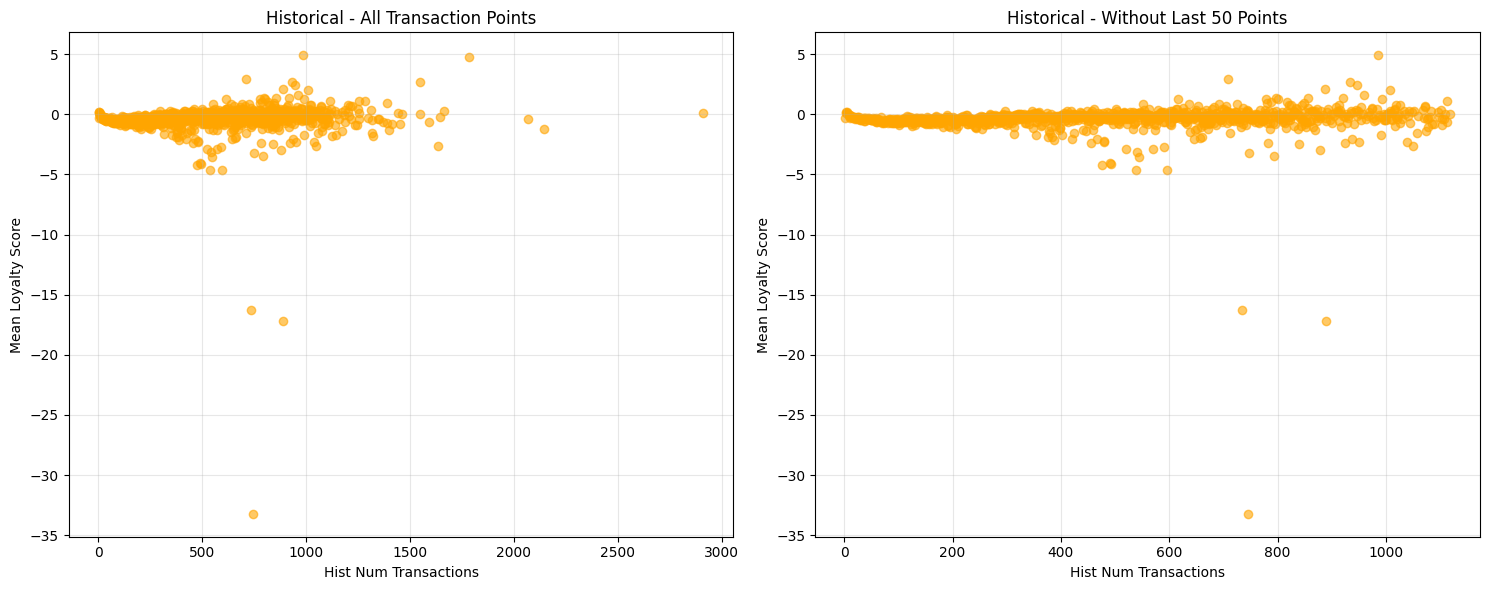

In [13]:
# For historical transactions
plot_loyalty_vs_transaction_count(
    df=train,
    count_col='hist_num_transactions',
    title_prefix='Historical - ',
    outlier_cutoff=50
)

### Bin Historical Transaction Count and Visualize Loyalty Score
We bin `hist_num_transactions` using predefined transaction ranges and then plot a boxplot of the loyalty score per bin.

**Observation**:
- Binning allows us to smooth out noise and understand average loyalty score behavior across different user segments.
- Generally, loyalty scores decline with increased transaction volume, except at extreme ends.


/tmp/ipykernel_297450/4282323346.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt_srs_binned = train.groupby("binned_hist_num_transactions")["target"].mean()



Mean loyalty score by binned transaction counts:
binned_hist_num_transactions
(0, 10]         0.018791
(10, 20]       -0.239937
(20, 30]       -0.322822
(30, 40]       -0.396614
(40, 50]       -0.383919
(50, 75]       -0.487289
(75, 100]      -0.545137
(100, 150]     -0.500725
(150, 200]     -0.498041
(200, 500]     -0.435845
(500, 10000]   -0.339671
Name: target, dtype: float64


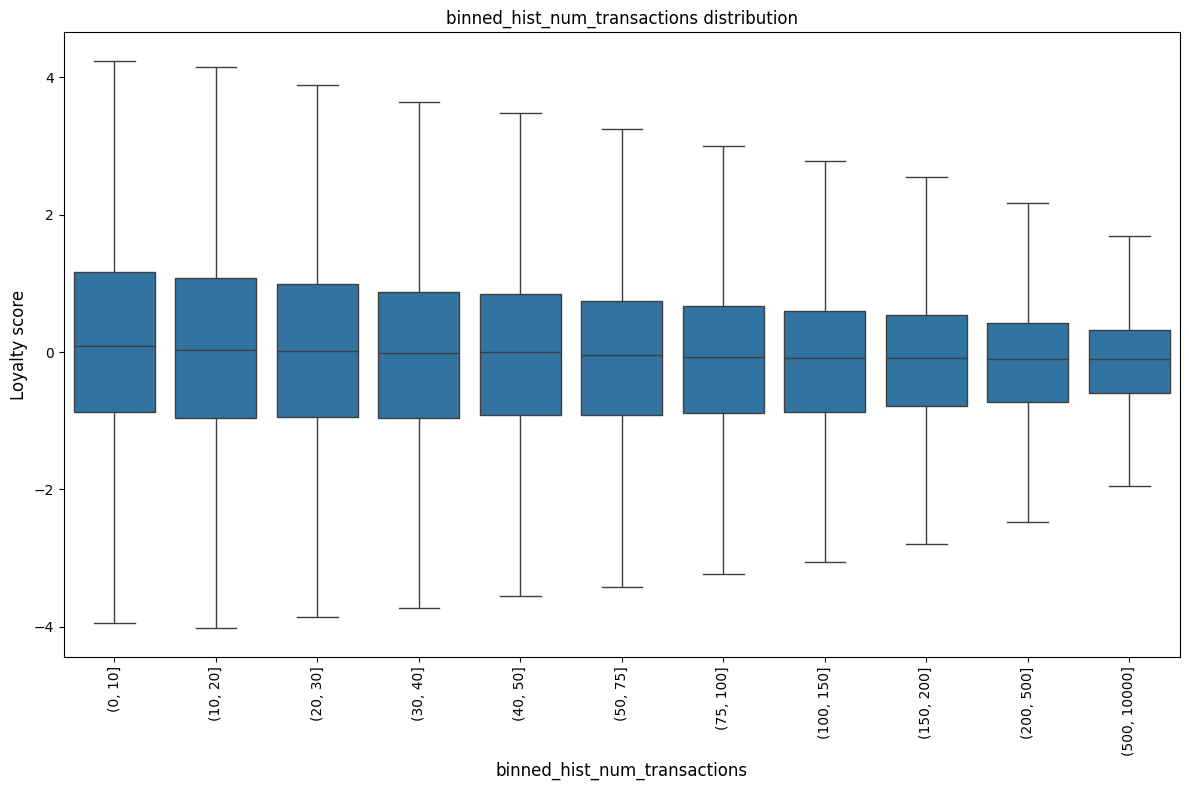

In [15]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train['binned_hist_num_transactions'] = pd.cut(train['hist_num_transactions'], bins)

# Calculate mean loyalty score by binned transactions
cnt_srs_binned = train.groupby("binned_hist_num_transactions")["target"].mean()
print("\nMean loyalty score by binned transaction counts:")
print(cnt_srs_binned)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_hist_num_transactions", y="target", data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_hist_num_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_hist_num_transactions distribution")
plt.tight_layout()

In [ ]:
# Import `new_merchant_transactions.csv`, which includes recent purchases from newly onboarded merchants.
# These represent a different customer behavior pattern than historical transactions.
new_transactions = pd.read_csv("data/new_merchant_transactions.csv")
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [ ]:
# Aggregate and Merge New Merchant Transaction Features
# We reuse the earlier aggregation function to extract statistical features (`sum`, `mean`, etc.) from the new merchant transaction data and merge them into the main train and test datasets.
new_transaction_stats = aggregate_transaction_amount_stats(new_transactions, prefix="new")

# Merge with training and test set
train = train.merge(new_transaction_stats, on="card_id", how="left")
test = test.merge(new_transaction_stats, on="card_id", how="left")

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,hist_num_transactions,hist_sum_transactions,...,hist_std_transactions,hist_min_transactions,hist_max_transactions,binned_hist_num_transactions,new_num_transactions,new_sum_transactions,new_mean_transactions,new_std_transactions,new_min_transactions,new_max_transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,260,-165.968739,...,0.212139,-0.739395,2.258395,"(200, 500]",23.0,-13.244202,-0.575835,0.135812,-0.724368,-0.296112
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,350,-210.006336,...,0.384967,-0.742400,4.630299,"(200, 500]",6.0,-4.355735,-0.725956,0.014326,-0.739410,-0.701858
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,43,-29.167391,...,0.087380,-0.730138,-0.145847,"(40, 50]",1.0,-0.700326,-0.700326,NaN,-0.700326,-0.700326
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,77,-49.491364,...,0.261624,-0.740897,1.445596,"(75, 100]",7.0,-4.654372,-0.664910,0.065882,-0.734135,-0.566740
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,133,-48.687656,...,1.352094,-0.746156,7.193041,"(100, 150]",36.0,-19.926237,-0.553507,0.223821,-0.739395,0.450886


### Visualize Loyalty Score vs New Merchant Transaction Count
This plot shows how the number of new merchant transactions relates to loyalty score.

**Insight**:
- Loyalty scores tend to drop with increasing new transaction counts.


/tmp/ipykernel_297450/3547160873.py:31: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  cnt_srs_filtered = cnt_srs[:-outlier_cutoff]


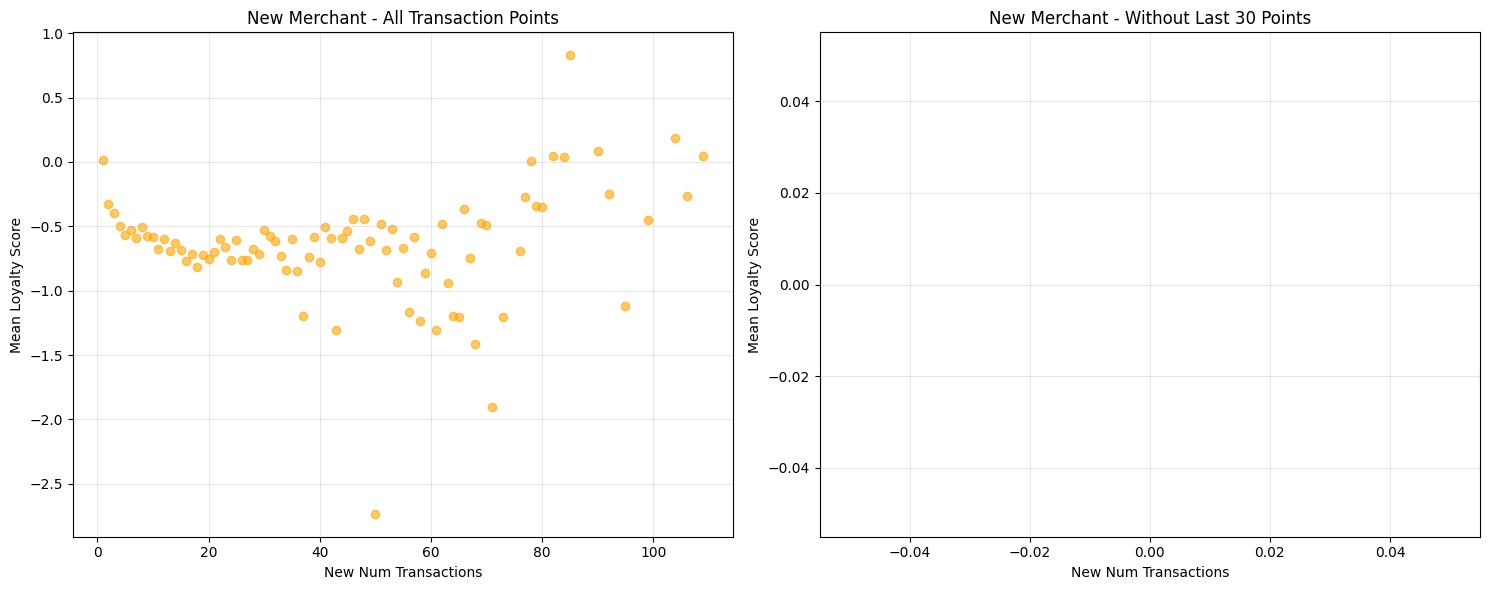

In [ ]:
# For new merchant transactions
plot_loyalty_vs_transaction_count(
    df=train,
    count_col='new_num_transactions',
    title_prefix='New Merchant - ',
    outlier_cutoff=30
)

### Bin New Merchant Transaction Count and Analyze Loyalty
We bin `new_num_transactions` into ranges and plot loyalty scores to understand how recent merchant activity correlates with loyalty.

**Observation**:
- Users with very few or very high new transactions show more variation in loyalty.
- Binning again helps uncover group trends over raw noise.


/tmp/ipykernel_297450/4138162769.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cnt_srs_binned = train.groupby("binned_num_new_transactions")["target"].mean()



Mean loyalty score by binned transaction counts:
binned_num_new_transactions
(0, 10]       -0.385467
(10, 20]      -0.685215
(20, 30]      -0.678870
(30, 40]      -0.724951
(40, 50]      -0.731390
(50, 75]      -0.792230
(75, 10000]   -0.145949
Name: target, dtype: float64


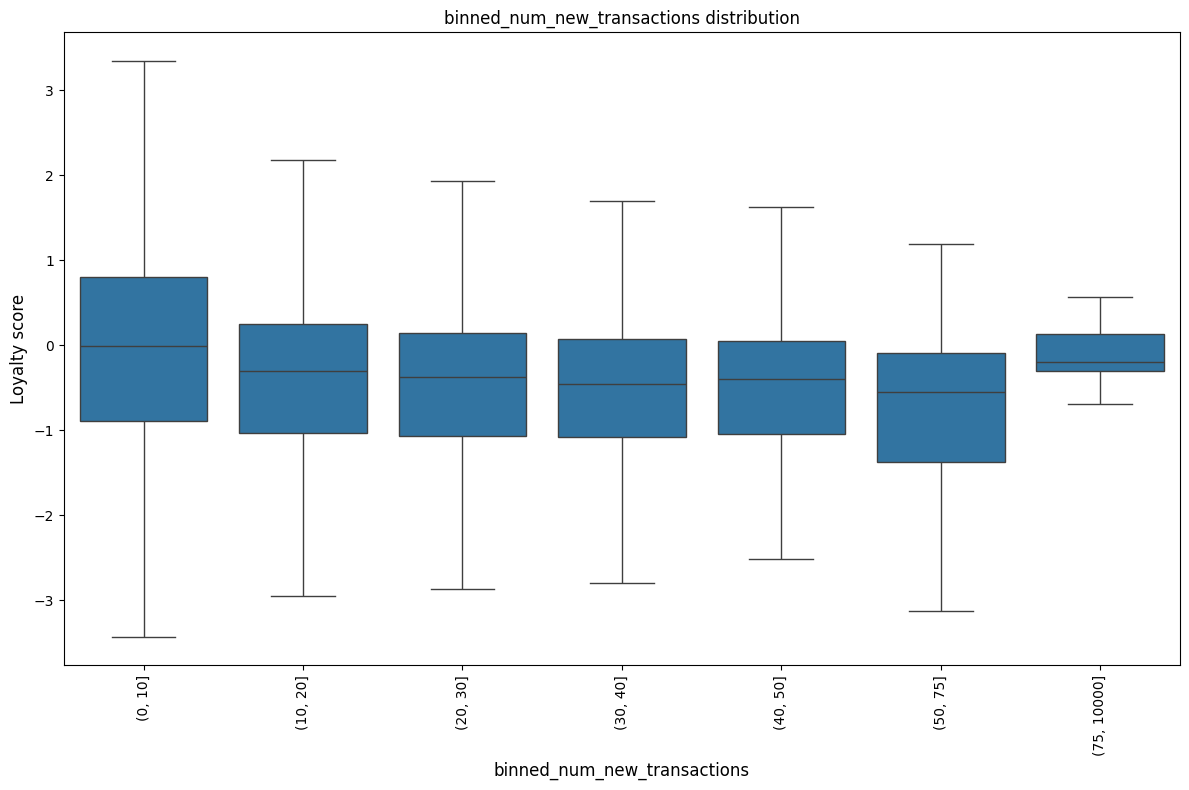

In [20]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train['binned_num_new_transactions'] = pd.cut(train['new_num_transactions'], bins)

# Calculate mean loyalty score by binned transactions
cnt_srs_binned = train.groupby("binned_num_new_transactions")["target"].mean()
print("\nMean loyalty score by binned transaction counts:")
print(cnt_srs_binned)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_new_transactions", y="target", data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_new_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_new_transactions distribution")
plt.tight_layout()

### Encode Category Features (category_1, category_2, category_3)
We convert categorical fields in transaction data into numeric aggregates per `card_id`:

- `category_1`: loyalty participation flag → proportion of "Y" values
- `category_2`: service level (ordinal) → mean value
- `category_3`: tier level (mapped A=0, B=1, C=2) → mean value

These are averaged per user and merged into train/test, helping capture user preferences and behaviors.


In [21]:
# Encode category and merge back to train and test
def process_transaction_categories(df, prefix):
    # category_1: binary ("Y"/"N") → (1/0)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0})

    category_1_agg = df.groupby('card_id')['category_1'].agg(['mean', 'sum']).reset_index()
    category_1_agg.columns = ['card_id', f'{prefix}_category_1_mean', f'{prefix}_category_1_sum']

    # category_2: ordinal (1.0 / 2.0 / 3.0)
    category_2_agg = df.groupby('card_id')['category_2'].agg(['mean']).reset_index()
    category_2_agg.columns = ['card_id', f'{prefix}_category_2_mean']

    # category_3: ordinal letters ("A", "B", "C") → (0, 1, 2)
    df['category_3'] = df['category_3'].map({'A': 0, 'B': 1, 'C': 2})
    category_3_agg = df.groupby('card_id')['category_3'].agg(['mean']).reset_index()
    category_3_agg.columns = ['card_id', f'{prefix}_category_3_mean']

    # Merge all
    agg = category_1_agg.merge(category_2_agg, on='card_id', how='outer')
    agg = agg.merge(category_3_agg, on='card_id', how='outer')
    return agg


# Process both
hist_cat_agg = process_transaction_categories(historical_transactions, prefix="hist")
new_cat_agg = process_transaction_categories(new_transactions, prefix="new")

# Merge into train and test
train = train.merge(hist_cat_agg, on="card_id", how="left")
train = train.merge(new_cat_agg, on="card_id", how="left")

test = test.merge(hist_cat_agg, on="card_id", how="left")
test = test.merge(new_cat_agg, on="card_id", how="left")

train.head()


,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,hist_num_transactions,hist_sum_transactions,...,new_max_transactions,binned_num_new_transactions,hist_category_1_mean,hist_category_1_sum,hist_category_2_mean,hist_category_3_mean,new_category_1_mean,new_category_1_sum,new_category_2_mean,new_category_3_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,260,-165.968739,...,-0.296112,"(20, 30]",0.000000,0,1.046154,0.015385,0.000000,0.0,1.000000,0.000000
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,350,-210.006336,...,-0.701858,"(0, 10]",0.088571,31,1.000000,1.206897,0.000000,0.0,1.000000,1.000000
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,43,-29.167391,...,-0.700326,"(0, 10]",0.000000,0,4.627907,0.000000,0.000000,0.0,5.000000,0.000000
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,77,-49.491364,...,-0.566740,"(0, 10]",0.155844,12,3.446154,1.093333,0.142857,1.0,4.000000,1.000000
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,133,-48.687656,...,0.450886,"(30, 40]",0.112782,15,3.754237,1.052632,0.055556,2.0,3.617647,1.028571


In [23]:
# Feature Engineering
# 1. Tenure (months active)
train['months_active'] = (12 * (2018 - train['first_active_month'].dt.year) + (2 - train['first_active_month'].dt.month))

# 2. Mean monthly spend from historical transactions
train['mean_monthly_spend'] = train['hist_sum_transactions'] / (train['months_active'] + 1)

# 3. Ratio of new to historical transactions
train['new_to_hist_transaction_ratio'] = train['new_num_transactions'] / (train['hist_num_transactions'] + 1)

# 4. Change in average spend
train['avg_spend_change'] = train['new_mean_transactions'] - train['hist_mean_transactions']
train['avg_spend_ratio'] = train['new_mean_transactions'] / (train['hist_mean_transactions'] + 1)

# 5. Refund ratio (we have negative amount)
if 'new_sum_neg_transactions' in train.columns and 'new_sum_pos_transactions' in train.columns:
    train['refund_ratio'] = train['new_sum_neg_transactions'].abs() / (train['new_sum_pos_transactions'] + 1)

# 6. Loyalty participation intensity
if 'hist_category_1_mean' in train.columns:
    train['loyalty_participation_score'] = train['hist_category_1_mean'] * train['hist_num_transactions']

# 7. Target encoding for binned features (example for binned_num_new_transactions)
if 'binned_num_new_transactions' in train.columns:
    train['bin_target_mean'] = train.groupby('binned_num_new_transactions')['target'].transform('mean')


/tmp/ipykernel_297450/3276207168.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train['bin_target_mean'] = train.groupby('binned_num_new_transactions')['target'].transform('mean')


In [24]:
train[[
    'months_active',
    'mean_monthly_spend',
    'new_to_hist_transaction_ratio',
    'avg_spend_change',
    'refund_ratio' if 'refund_ratio' in train.columns else 'hist_num_transactions',
    'loyalty_participation_score' if 'loyalty_participation_score' in train.columns else 'hist_num_transactions',
    'bin_target_mean' if 'bin_target_mean' in train.columns else 'target'
]].head()


,months_active,mean_monthly_spend,new_to_hist_transaction_ratio,avg_spend_change,hist_num_transactions,loyalty_participation_score,bin_target_mean
0,8,-18.440971,0.088123,0.062506,260,0.0,-0.678870
1,13,-15.000453,0.017094,-0.125938,350,31.0,-0.385467
2,18,-1.535126,0.022727,-0.022014,43,0.0,-0.385467
3,5,-8.248561,0.089744,-0.022165,77,12.0,-0.385467
4,3,-12.171914,0.268657,-0.187434,133,15.0,-0.724951


In [25]:
# Apply feature engineering to test set
test['months_active'] = (12 * (2018 - train['first_active_month'].dt.year) + (2 - train['first_active_month'].dt.month))
test['mean_monthly_spend'] = test['hist_sum_transactions'] / (test['months_active'] + 1)
test['new_to_hist_transaction_ratio'] = test['new_num_transactions'] / (test['hist_num_transactions'] + 1)
test['avg_spend_change'] = test['new_mean_transactions'] - test['hist_mean_transactions']

if 'new_sum_neg_transactions' in test.columns and 'new_sum_pos_transactions' in test.columns:
    test['refund_ratio'] = test['new_sum_neg_transactions'].abs() / (test['new_sum_pos_transactions'] + 1)

if 'hist_category_1_mean' in test.columns:
    test['loyalty_participation_score'] = test['hist_category_1_mean'] * test['hist_num_transactions']

# Map binned target mean from train to test
if 'binned_num_new_transactions' in test.columns and 'binned_num_new_transactions' in train.columns:
    bin_target_map = train.groupby('binned_num_new_transactions')['target'].mean().to_dict()
    test['bin_target_mean'] = test['binned_num_new_transactions'].map(bin_target_map)
    
test.head()


,first_active_month,card_id,feature_1,feature_2,feature_3,year,hist_num_transactions,hist_sum_transactions,hist_mean_transactions,hist_std_transactions,...,hist_category_3_mean,new_category_1_mean,new_category_1_sum,new_category_2_mean,new_category_3_mean,months_active,mean_monthly_spend,new_to_hist_transaction_ratio,avg_spend_change,loyalty_participation_score
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,2017,68,-40.733733,-0.599025,0.192268,...,1.323529,0.000000,0.0,1.000000,1.333333,8,-4.525970,0.043478,0.006640,23.0
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,2017,78,-49.136513,-0.629955,0.154999,...,1.025641,0.222222,2.0,4.000000,1.111111,13,-3.509751,0.113924,-0.030567,2.0
2,2017-08-01,C_ID_b709037bc5,5,1,1,2017,13,4.528840,0.348372,0.906547,...,1.900000,0.500000,1.0,5.000000,1.500000,18,0.238360,0.142857,-0.258303,1.0
3,2017-12-01,C_ID_d27d835a9f,2,1,0,2017,26,-13.690715,-0.526566,0.219162,...,1.291667,0.100000,1.0,1.444444,1.500000,5,-2.281786,0.370370,-0.047801,0.0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,2015,110,25.139384,0.228540,2.777764,...,1.054545,0.000000,0.0,3.833333,1.200000,3,6.284846,0.054054,1.782293,0.0
